<a href="https://www.kaggle.com/code/mohamedouaicha/compare-gru-lstm-and-transformer-on-solar-dataset?scriptVersionId=169492543" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import (
    LSTM,
    GRU,
    Dense,
    Dropout,
    Input,
    LayerNormalization,
    MultiHeadAttention,
    Conv1D,
    GlobalAveragePooling1D,
)


2024-03-30 21:35:46.276190: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 21:35:46.276340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 21:35:46.395162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# functions

In [2]:
def reg_data(df):
    df = df.drop(df.index[[0,1,2]])
    df = df.drop('MW', axis=1)
    df.columns = ['Date', 'From', 'to', 'MW']
    
    dates = df['Date'].tolist()

    days = []
    months = []
    years = []
    for date in dates:
        days.append(date.split('.')[0])
        months.append(date.split('.')[1])
        years.append(date.split('.')[2])

    df['Day'] = days
    df['Month'] = months
    df['Year'] = years
    
    def fixMW(cols):
        TT = cols
        TT = TT.replace('.','')
        TT = TT.replace(',','.')
        return TT

    df['MW'] = df['MW'].apply(fixMW).astype(float)
    df['Day'] = df['Day'].astype(int)
    df['Month'] = df['Month'].astype(int)
    df['Year'] = df['Year'].astype(int)
    
    df = df.groupby(['Day','Month','Year'])['MW'].sum()
    df = pd.DataFrame(df)
    df['Month'] = df.index.get_level_values('Month') 
    df['Day'] = df.index.get_level_values('Day') 
    df['Year'] = df.index.get_level_values('Year') 
    df.reset_index(drop=True, inplace=True)
    return df


def split_data(df):
    train_size = int(len(df) * 0.75)
    test_size = len(df) - train_size
    train, test = df[0:train_size,:], df[train_size:len(df),:]
    return train, test

def Split_weekly(df, look_back=7):
	dataX, dataY = [], []
	for i in range(len(df)-look_back-1):
		a = df[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(df[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


def ploter_Erreur(hist):
    f, axarr = plt.subplots(1,1, figsize=(20, 5))

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    axarr.set_title('Model loss')
    axarr.set_ylabel('Loss')
    axarr.set_xlabel('Epoch')
    axarr.legend(['Entrainement', 'validation'], loc='upper left')
    plt.show()

# Load and preprocess data

In [3]:
Data_10 = pd.read_csv('/kaggle/input/my-solar-energy/2010.csv',sep=';')
Data_10 = reg_data(Data_10)

Data_11 = pd.read_csv('/kaggle/input/my-solar-energy/2011.csv',sep=';')
Data_11 = reg_data(Data_11)

Data_12 = pd.read_csv('/kaggle/input/my-solar-energy/2012.csv',sep=';')
Data_12 = reg_data(Data_12)

Data_13 = pd.read_csv('/kaggle/input/my-solar-energy/2013.csv',sep=';')
Data_13 = reg_data(Data_13)

Data_14 = pd.read_csv('/kaggle/input/my-solar-energy/2014.csv',sep=';')
Data_14 = reg_data(Data_14)
Data_15 = pd.read_csv('/kaggle/input/my-solar-energy/2015.csv',sep=';')
Data_15 = reg_data(Data_15)

Data_16 = pd.read_csv('/kaggle/input/my-solar-energy/2016.csv',sep=';')
Data_16 = reg_data(Data_16)

Data_17 = pd.read_csv('/kaggle/input/my-solar-energy/2017.csv',sep=';')
Data_17.head()
Data_17 = reg_data(Data_17)

Data_18 = pd.read_csv('/kaggle/input/my-solar-energy/2018.csv',sep=';')
Data_18 = reg_data(Data_18)

Data_19 = pd.read_csv('/kaggle/input/my-solar-energy/2019.csv',sep=';')
Data_19 = reg_data(Data_19)

Data_20 = pd.read_csv('/kaggle/input/my-solar-energy/2020.csv',sep=';')
Data_20 = reg_data(Data_20)

Data_21 = pd.read_csv('/kaggle/input/my-solar-energy/2021.csv',sep=';')
Data_21 = reg_data(Data_21)

Data_22 = pd.read_csv('/kaggle/input/my-solar-energy/2022.csv',sep=';')
Data_22 = reg_data(Data_22)

Data_23 = pd.read_csv('/kaggle/input/my-solar-energy/2023.csv',sep=';')
Data_23 = reg_data(Data_23)

Data_24 = pd.read_csv('/kaggle/input/my-solar-energy/2024.csv',sep=';')
Data_24 = reg_data(Data_24)


DataFrame = pd.concat([ Data_10, Data_11, Data_12, Data_13,Data_14, Data_15, Data_16, Data_17, Data_18, Data_19, Data_20, Data_21, Data_22, Data_23, Data_24], ignore_index=True)
model_data = DataFrame


scaler = MinMaxScaler(feature_range=(0, 1))
model_data = scaler.fit_transform(model_data)

train, test = split_data(model_data)
print(len(model_data))
print(len(train))
print(len(test))

5203
3902
1301


# Split data into train and test sets

In [4]:
X_train, y_train = Split_weekly(train)
X_test, y_test = Split_weekly(test)

# Reshape data for LSTM and GRU

In [5]:
X_train_lstm_gru_transformer = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm_gru_transformer = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define models

## Hyper-params

In [6]:
lstm_gru_layers = (8,16)
Transformer_fine_tuning  = {
    "1":{"head_size":256,
         "num_heads":4,
         "ff_dim":4,
         "num_transformer_blocks":4,
         "mlp_units":[128],
         "mlp_dropout":0.4,
         "dropout":0.2
         },
    "2":{"head_size":256,
            "num_heads":8,
            "ff_dim":8,
            "num_transformer_blocks":8,
            "mlp_units":[128],
            "mlp_dropout":0.3,
            "dropout":0.3
            },
    "3":{"head_size":256,
            "num_heads":4,
            "ff_dim":4,
            "num_transformer_blocks":8,
            "mlp_units":[128],
            "mlp_dropout":0.1,
            "dropout":0.3},
    "4":{"head_size":128,
            "num_heads":8,
            "ff_dim":8,
            "num_transformer_blocks":8,
            "mlp_units":[128],
            "mlp_dropout":0.4,
            "dropout":0.2},
}
Transformer_layer = Transformer_fine_tuning["1"]
epochs = 50

In [7]:
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=lstm_gru_layers[0], return_sequences=True, input_shape=(7, 1)))
    model.add(Dropout(Transformer_layer["dropout"]))
    model.add(LSTM(units=lstm_gru_layers[1]))
    model.add(Dropout(Transformer_layer["dropout"]))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    return model

def create_gru_model():
    model = Sequential()
    model.add(GRU(units=lstm_gru_layers[0], return_sequences=True, input_shape=(7, 1)))
    model.add(Dropout(Transformer_layer["dropout"]))
    model.add(GRU(units=lstm_gru_layers[1]))
    model.add(Dropout(Transformer_layer["dropout"]))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    return model
def transformer_encoder(inputs):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=Transformer_layer["head_size"], num_heads=Transformer_layer["num_heads"], dropout=Transformer_layer["dropout"]
    )(x, x)
    x = Dropout(Transformer_layer["dropout"])(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Conv1D(filters=Transformer_layer["ff_dim"], kernel_size=1, activation="relu")(x)
    x = Dropout(Transformer_layer["dropout"])(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res
def create_transformer_model():
    inputs = Input(shape=(7, 1))
    x = inputs
    for _ in range(Transformer_layer["num_transformer_blocks"]):
        x = transformer_encoder(x)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in Transformer_layer["mlp_units"]:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(Transformer_layer["mlp_dropout"])(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    model.compile(loss="mse", optimizer="adam")
    return model
   

# Create and train models

In [8]:
lstm_model = create_lstm_model()
gru_model = create_gru_model()
transformer_model = create_transformer_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## LSTM

In [9]:
lstm_history = lstm_model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=8, verbose=1)


Epoch 1/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0206 - val_loss: 0.0426
Epoch 2/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0144 - val_loss: 0.0418
Epoch 3/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0126 - val_loss: 0.0320
Epoch 4/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0110 - val_loss: 0.0288
Epoch 5/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0106 - val_loss: 0.0264
Epoch 6/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0103 - val_loss: 0.0265
Epoch 7/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0100 - val_loss: 0.0258
Epoch 8/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0231
Epoch 9/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0256
Epoch 10/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0087 - val_loss: 0.0231
Epoch 11/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0081 - val_loss: 0.0220
Epoch 12/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

## GRU

In [10]:
gru_history = gru_model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=8, verbose=1)


Epoch 1/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0195 - val_loss: 0.0235
Epoch 2/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0105 - val_loss: 0.0290
Epoch 3/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0099 - val_loss: 0.0245
Epoch 4/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0098 - val_loss: 0.0251
Epoch 5/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0097 - val_loss: 0.0244
Epoch 6/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0223
Epoch 7/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0087 - val_loss: 0.0207
Epoch 8/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0087 - val_loss: 0.0201
Epoch 9/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0081 - val_loss: 0.0206
Epoch 10/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0082 - val_loss: 0.0208
Epoch 11/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0084 - val_loss: 0.0179
Epoch 12/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

## Transformer

In [11]:
transformer_history = transformer_model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=8, verbose=1)

Epoch 1/50
 33/390 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0285

I0000 00:00:1711834791.653133      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


390/390 ━━━━━━━━━━━━━━━━━━━━ 68s 77ms/step - loss: 0.0154 - val_loss: 0.0192
Epoch 2/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0084 - val_loss: 0.0214
Epoch 3/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0073 - val_loss: 0.0168
Epoch 4/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0075 - val_loss: 0.0196
Epoch 5/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0079 - val_loss: 0.0193
Epoch 6/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0076 - val_loss: 0.0171
Epoch 7/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0077 - val_loss: 0.0175
Epoch 8/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0067 - val_loss: 0.0176
Epoch 9/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0072 - val_loss: 0.0201
Epoch 10/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0068 - val_loss: 0.0192
Epoch 11/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0071 - val_loss: 0.0175
Epoch 12/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 

# Evaluate models

In [12]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2-score: {r2:.4f}")
    return y_pred


lstm_predictions = evaluate_model(lstm_model, X_test_lstm_gru_transformer, y_test)
gru_predictions = evaluate_model(gru_model, X_test_lstm_gru_transformer, y_test)
transformer_predictions = evaluate_model(transformer_model, X_test_lstm_gru_transformer, y_test)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE: 0.0437
RMSE: 0.2090
MAE: 0.1590
R2-score: 0.3300
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE: 0.0402
RMSE: 0.2004
MAE: 0.1543
R2-score: 0.3838
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
MSE: 0.0377
RMSE: 0.1943
MAE: 0.1470
R2-score: 0.4210


# Visualize results

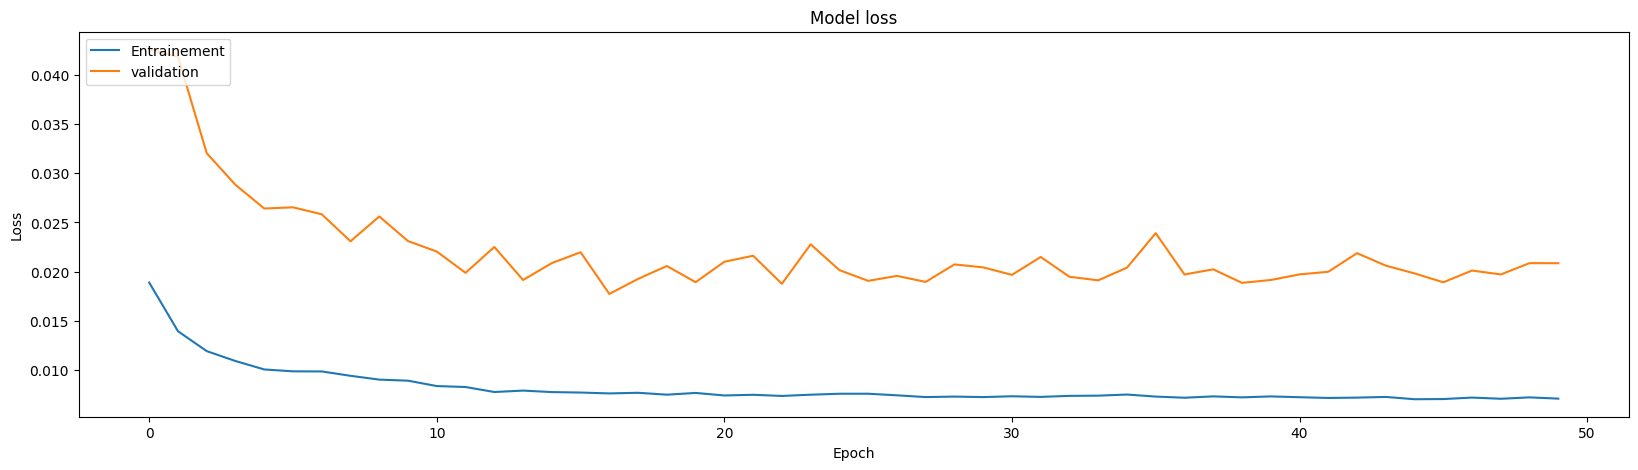

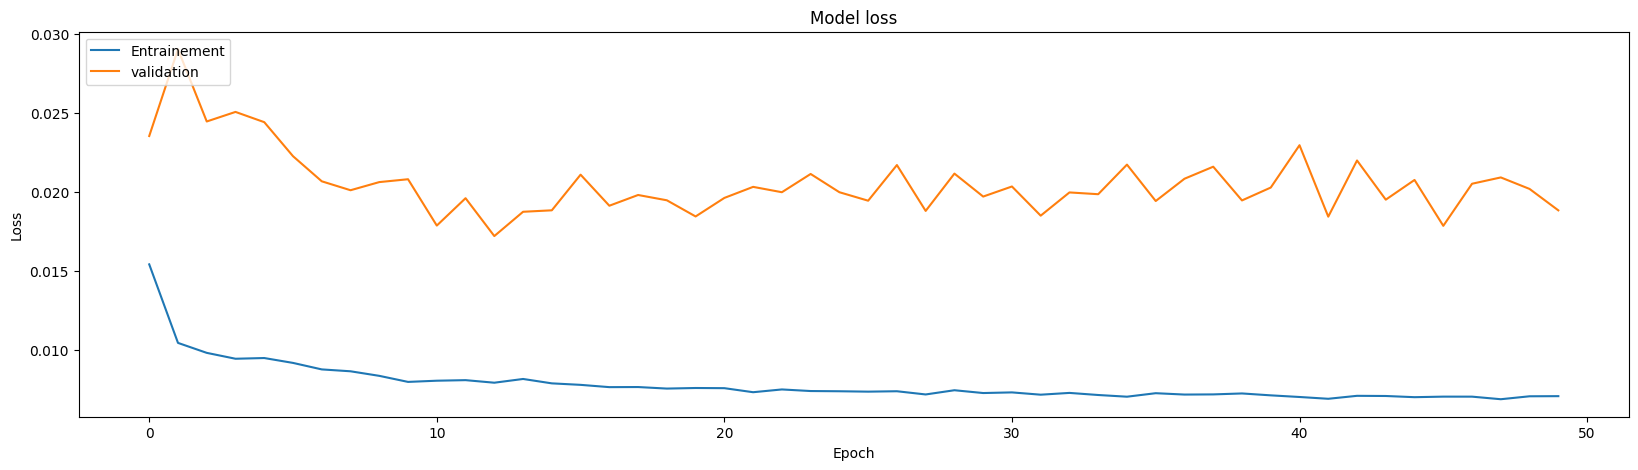

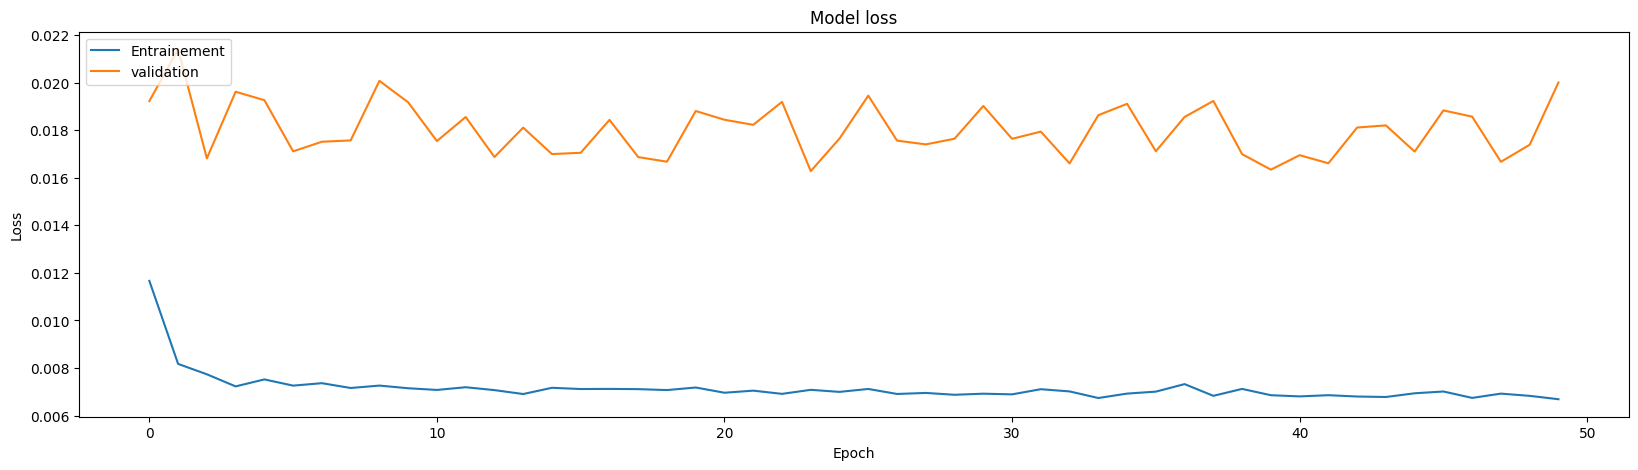

In [13]:
ploter_Erreur(lstm_history)
ploter_Erreur(gru_history)
ploter_Erreur(transformer_history)


# predictions

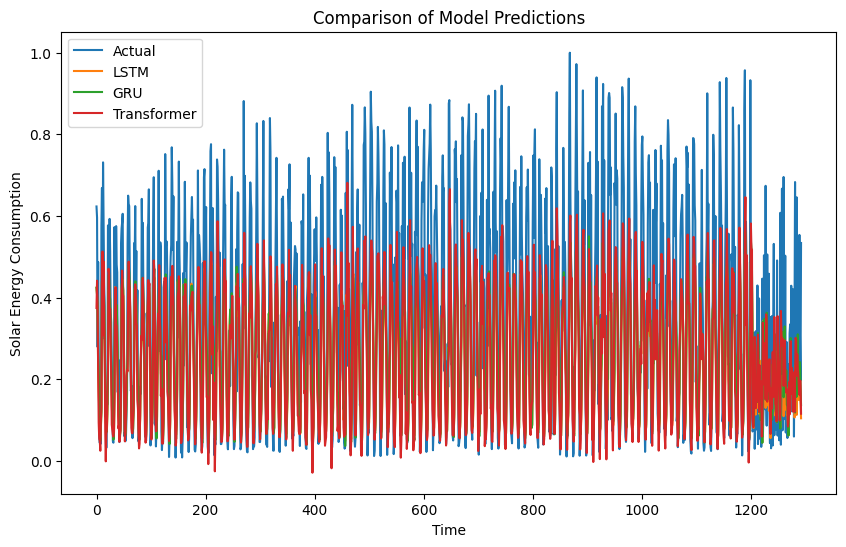

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual")
plt.plot(lstm_predictions, label="LSTM")
plt.plot(gru_predictions, label="GRU")
plt.plot(transformer_predictions, label="Transformer")

plt.xlabel("Time")
plt.ylabel("Solar Energy Consumption")
plt.title("Comparison of Model Predictions")
plt.legend()
plt.show()


# Loss functions

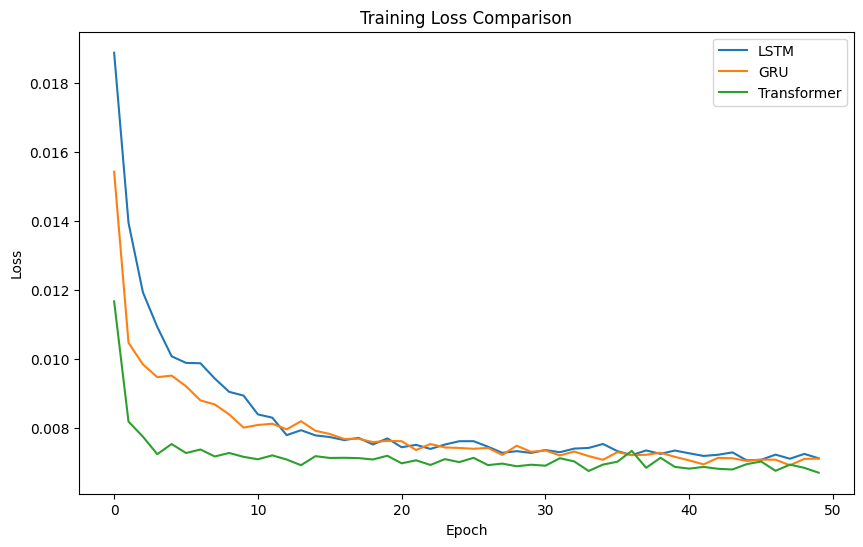

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'], label="LSTM")
plt.plot(gru_history.history['loss'], label="GRU")
plt.plot(transformer_history.history['loss'], label="Transformer")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()